In [1]:
# Author: Alex Trostanovsky, 31-08-2018
#
# This notebook contains the Exploratory Data Analysis I've conducted on Lending Club data
# Using third party data sources from:
# -  United States Department of Labour
# -  International Health Organization
#
# This notebook:
#
# 1) splits into training/testing datasets, and trains a LightGBM classifier to categorize loan candidates who're are likely
#    to default (e.g. either 'Charged Off', 'Default', '30-120 Days Late)
#
# 2) produces cross-validation (AUCROC) metric result on the testing data-set with the trained model
#
# 3) generates a '_feature_importances' table for the trained model 

from contextlib               import contextmanager
from lightgbm                 import LGBMClassifier
from lightgbm                 import LGBMRegressor
from sklearn.metrics          import roc_auc_score, roc_curve
from sklearn.metrics          import mean_squared_error
from sklearn.model_selection  import KFold, StratifiedKFold
from sklearn.cross_validation import train_test_split
from math                     import sqrt
from tqdm                     import tqdm

import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


F:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('../images/feature_importances/lgbm_importances01.png')

In [4]:
df = pd.read_csv('../data/exports/preproc_lc.csv')
# export adds redundant column for index values; get rid of that
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [5]:
train_df, test_df = train_test_split(df, test_size = 0.2)

In [6]:
train_y = train_df.pop('target')
train_X = train_df
test_y  = test_df.pop('target')
test_X  = test_df

In [8]:
clf = LGBMClassifier(
            nthread=4,
            n_estimators=2000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

In [9]:
clf.fit(train_X, train_y, eval_set=[(train_X, train_y), (test_X, test_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.777638	valid_1's auc: 0.773075
[200]	training's auc: 0.789289	valid_1's auc: 0.780372
[300]	training's auc: 0.798836	valid_1's auc: 0.786463
[400]	training's auc: 0.805549	valid_1's auc: 0.789527
[500]	training's auc: 0.81155	valid_1's auc: 0.792269
[600]	training's auc: 0.816341	valid_1's auc: 0.793804
[700]	training's auc: 0.820565	valid_1's auc: 0.795064
[800]	training's auc: 0.824541	valid_1's auc: 0.79577
[900]	training's auc: 0.828052	valid_1's auc: 0.796397
[1000]	training's auc: 0.831359	valid_1's auc: 0.796866
[1100]	training's auc: 0.834423	valid_1's auc: 0.797301
[1200]	training's auc: 0.837411	valid_1's auc: 0.79763
[1300]	training's auc: 0.840277	valid_1's auc: 0.797845
[1400]	training's auc: 0.843021	valid_1's auc: 0.79807
[1500]	training's auc: 0.845716	valid_1's auc: 0.798312
[1600]	training's auc: 0.848185	valid_1's auc: 0.798449
[1700]	training's auc: 0.850681	valid_1's auc: 0.79852

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
        min_child_samples=20, min_child_weight=39.3259775,
        min_split_gain=0.0222415, n_estimators=2000, n_jobs=-1, nthread=4,
        num_leaves=34, objective=None, random_state=None,
        reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
        subsample=0.8715623, subsample_for_bin=200000, subsample_freq=0,
        verbose=-1)

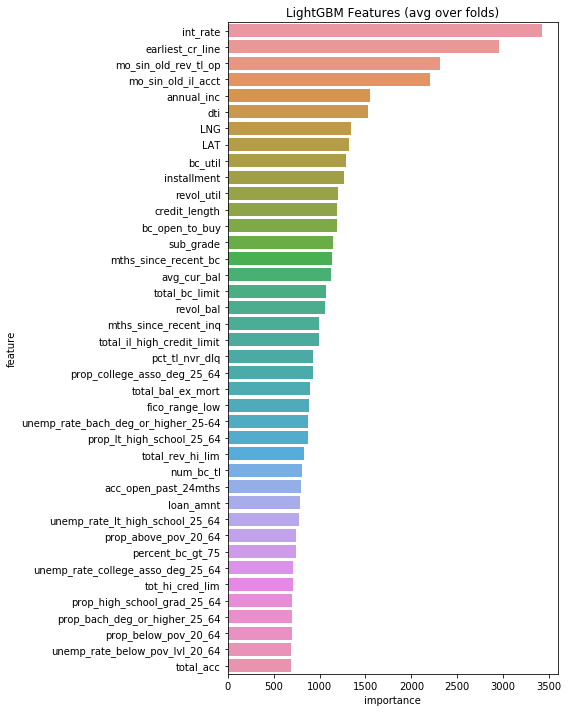

In [11]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature']    = train_X.columns.tolist()
feature_importance_df['importance'] = clf.feature_importances_
display_importances(feature_importance_df)